In [50]:
# ============================
# 03_model_training.ipynb (FULL)
# Network Traffic Anomaly Detection (NSL-KDD)
# Training: Hierarchical IDS (Binary -> Multi on Attacks)
# Works with NUMERIC y_train_multi (0..K-1) + label_encoder.pkl
# ============================

# Cell 1 — Imports & robust paths
import os
import json
import time
import joblib
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    roc_curve,
)

import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# --- Robust project root resolution ---
# If running from notebooks/, PROJECT_ROOT should be the parent folder of notebooks/
if "__file__" in globals():
    PROJECT_ROOT = Path(__file__).resolve().parents[1]
else:
    # When running inside Jupyter, cwd is typically <project_root>/notebooks
    # so parents[0] is <project_root>
    PROJECT_ROOT = Path.cwd().resolve().parents[0]

DATA_DIR = PROJECT_ROOT / "data" / "processed"
RESULTS_DIR = PROJECT_ROOT / "results"
MODELS_DIR = RESULTS_DIR / "models"
METRICS_DIR = RESULTS_DIR / "metrics"
FIGURES_DIR = RESULTS_DIR / "figures"

for d in [MODELS_DIR, METRICS_DIR, FIGURES_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_DIR:", DATA_DIR)
print("DATA_DIR exists:", DATA_DIR.exists())


PROJECT_ROOT: C:\Users\elair\Desktop\CS\cyber_bootcamp\Network-Traffic-Anomaly-Detection
DATA_DIR: C:\Users\elair\Desktop\CS\cyber_bootcamp\Network-Traffic-Anomaly-Detection\data\processed
DATA_DIR exists: True


In [51]:
# Cell 2 — Load processed arrays + feature names (optional)
X_train = np.load(DATA_DIR / "X_train.npy", allow_pickle=True)
X_test  = np.load(DATA_DIR / "X_test.npy",  allow_pickle=True)

y_train_multi = np.load(DATA_DIR / "y_train_multi.npy", allow_pickle=True)
y_test_multi  = np.load(DATA_DIR / "y_test_multi.npy",  allow_pickle=True)

feature_names_path = DATA_DIR / "feature_names.csv"
if feature_names_path.exists():
    feature_names = pd.read_csv(feature_names_path).iloc[:, 0].astype(str).tolist()
else:
    feature_names = [f"f{i}" for i in range(X_train.shape[1])]

print("X_train:", X_train.shape, X_train.dtype)
print("X_test :", X_test.shape, X_test.dtype)
print("y_train_multi:", y_train_multi.shape, y_train_multi.dtype, "unique:", np.unique(y_train_multi))
print("y_test_multi :", y_test_multi.shape, y_test_multi.dtype, "unique:", np.unique(y_test_multi))


X_train: (125973, 122) float64
X_test : (22544, 122) float64
y_train_multi: (125973,) int64 unique: [0 1 2 3 4]
y_test_multi : (22544,) int64 unique: [0 1 2 3 4]


In [52]:
# Cell 3 — Load label encoder & detect NORMAL_CODE robustly
label_encoder_path = DATA_DIR / "label_encoder.pkl"
if not label_encoder_path.exists():
    raise FileNotFoundError(f"Missing {label_encoder_path}. Run 02_preprocessing and save label_encoder.pkl")

le = joblib.load(label_encoder_path)

# le.classes_ should be array-like of string labels (e.g., ['DoS','Normal','Probe','R2L','U2R'])
classes_list = [str(c) for c in le.classes_]
print("Label encoder classes_:", classes_list)

normal_candidates = [c for c in le.classes_ if str(c).strip().lower() == "normal"]
if len(normal_candidates) == 0:
    raise ValueError(f"Couldn't find 'normal' in label encoder classes_. Got: {classes_list}")

NORMAL_LABEL_STR = str(normal_candidates[0])
NORMAL_CODE = int(le.transform([NORMAL_LABEL_STR])[0])

print("Detected NORMAL_LABEL_STR:", NORMAL_LABEL_STR)
print("Detected NORMAL_CODE:", NORMAL_CODE)

# Quick mapping table (code -> label)
mapping_df = pd.DataFrame({
    "code": np.arange(len(le.classes_)),
    "label": [str(x) for x in le.inverse_transform(np.arange(len(le.classes_)))]
})
mapping_df


Label encoder classes_: ['DoS', 'Normal', 'Probe', 'R2L', 'U2R']
Detected NORMAL_LABEL_STR: Normal
Detected NORMAL_CODE: 1


,code,label
0,0,DoS
1,1,Normal
2,2,Probe
3,3,R2L
4,4,U2R


In [53]:
# Cell 4 — Helpers (save + plots + threshold selection)
def save_json(obj, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, indent=2, ensure_ascii=False)

def plot_and_save_confusion_matrix(y_true, y_pred, labels, title, out_path: Path, normalize=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, values_format=".2f" if normalize else "d", cmap="Blues", colorbar=False)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()
    fig.savefig(out_path, dpi=200)
    plt.close(fig)

def plot_and_save_roc_pr(y_true_bin, y_score, title_prefix, out_dir: Path):
    # ROC
    fpr, tpr, _ = roc_curve(y_true_bin, y_score)
    fig1, ax1 = plt.subplots(figsize=(7, 5))
    ax1.plot(fpr, tpr)
    ax1.set_xlabel("False Positive Rate")
    ax1.set_ylabel("True Positive Rate")
    ax1.set_title(f"{title_prefix} - ROC Curve")
    plt.tight_layout()
    plt.show()
    fig1.savefig(out_dir / f"{title_prefix.lower().replace(' ', '_')}_roc.png", dpi=200)
    plt.close(fig1)

    # PR
    prec, rec, _ = precision_recall_curve(y_true_bin, y_score)
    fig2, ax2 = plt.subplots(figsize=(7, 5))
    ax2.plot(rec, prec)
    ax2.set_xlabel("Recall")
    ax2.set_ylabel("Precision")
    ax2.set_title(f"{title_prefix} - PR Curve")
    plt.tight_layout()
    plt.show()
    fig2.savefig(out_dir / f"{title_prefix.lower().replace(' ', '_')}_pr.png", dpi=200)
    plt.close(fig2)

def pick_threshold_for_recall(y_true_bin, y_score, target_recall=0.95):
    """
    Choose a decision threshold aiming for at least target_recall on the positive class (Attack=1).
    Returns (threshold, achieved_recall, achieved_precision).
    """
    prec, rec, thr = precision_recall_curve(y_true_bin, y_score)
    candidates = np.where(rec[:-1] >= target_recall)[0]
    if len(candidates) == 0:
        best_idx = int(np.argmax(rec[:-1]))
    else:
        best_idx = int(candidates[np.argmax(prec[:-1][candidates])])
    return float(thr[best_idx]), float(rec[:-1][best_idx]), float(prec[:-1][best_idx])


In [54]:
# Cell 5 — Build binary labels (Normal vs Attack) from numeric multi labels
y_train_bin = (y_train_multi != NORMAL_CODE).astype(int)
y_test_bin  = (y_test_multi  != NORMAL_CODE).astype(int)

print("Binary balance train:", dict(zip(*np.unique(y_train_bin, return_counts=True))))
print("Binary balance test :", dict(zip(*np.unique(y_test_bin, return_counts=True))))

# Safety: ensure 2 classes exist
u, c = np.unique(y_train_bin, return_counts=True)
assert len(u) == 2, f"Binary labels must have 2 classes. Got {dict(zip(u,c))}"


Binary balance train: {np.int64(0): np.int64(67343), np.int64(1): np.int64(58630)}
Binary balance test : {np.int64(0): np.int64(9711), np.int64(1): np.int64(12833)}


In [55]:
# Cell 6 — Train Binary Model (RF)
t0 = time.time()

binary_model = RandomForestClassifier(
    n_estimators=600,
    max_depth=25,
    min_samples_leaf=5,
    min_samples_split=10,
    class_weight="balanced",
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

binary_model.fit(X_train, y_train_bin)

t1 = time.time()
print(f"Binary model trained in {t1 - t0:.2f}s")
print("binary_model.classes_:", binary_model.classes_)


Binary model trained in 14.47s
binary_model.classes_: [0 1]


Binary ROC-AUC: 0.9648865539101462
Binary PR-AUC : 0.9697443531455943
Chosen threshold: 0.0147 (recall=0.9501, precision=0.9022)

=== Binary report (threshold=0.5) ===
              precision    recall  f1-score   support

      Normal     0.5297    1.0000    0.6926      9711
      Attack     1.0000    0.3281    0.4941     12833

    accuracy                         0.6175     22544
   macro avg     0.7649    0.6641    0.5933     22544
weighted avg     0.7974    0.6175    0.5796     22544


=== Binary report (tuned threshold) ===
              precision    recall  f1-score   support

      Normal     0.9290    0.8640    0.8953      9711
      Attack     0.9022    0.9501    0.9255     12833

    accuracy                         0.9130     22544
   macro avg     0.9156    0.9070    0.9104     22544
weighted avg     0.9138    0.9130    0.9125     22544



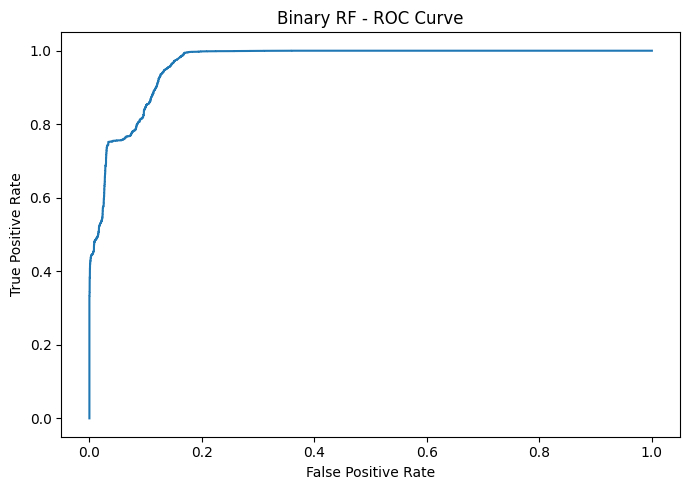

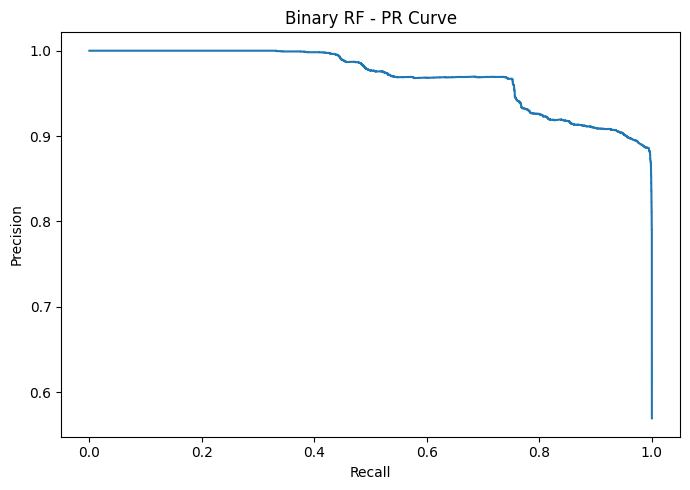

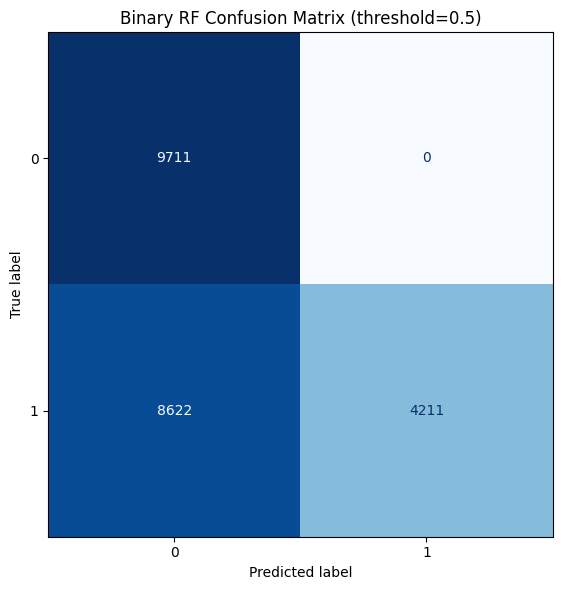

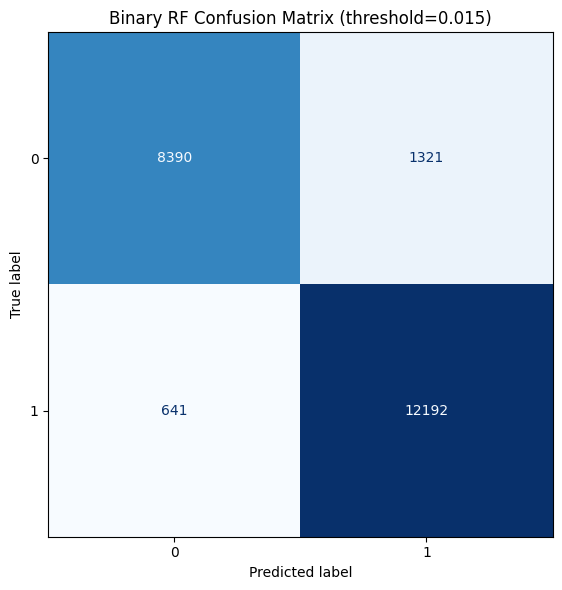

{'roc_auc': 0.9648865539101462,
 'pr_auc': 0.9697443531455943,
 'threshold': 0.014743805042196939,
 'threshold_target_recall': 0.95,
 'achieved_recall': 0.950050650666251,
 'achieved_precision': 0.9022422852068379}

In [56]:
# Cell 7 — Evaluate Binary Model (robust proba indexing + threshold tuning)
proba = binary_model.predict_proba(X_test)

# Robustly select probability column for class 1 (Attack)
if 1 in binary_model.classes_:
    attack_col = int(np.where(binary_model.classes_ == 1)[0][0])
    y_score_attack = proba[:, attack_col]
else:
    # Shouldn't happen after fixes, but keep safe
    y_score_attack = np.zeros(X_test.shape[0], dtype=float)

roc_auc = roc_auc_score(y_test_bin, y_score_attack)
pr_auc = average_precision_score(y_test_bin, y_score_attack)

threshold, achieved_recall, achieved_precision = pick_threshold_for_recall(
    y_test_bin, y_score_attack, target_recall=0.95
)

y_pred_bin_default = (y_score_attack >= 0.5).astype(int)
y_pred_bin_tuned   = (y_score_attack >= threshold).astype(int)

print("Binary ROC-AUC:", float(roc_auc))
print("Binary PR-AUC :", float(pr_auc))
print(f"Chosen threshold: {threshold:.4f} (recall={achieved_recall:.4f}, precision={achieved_precision:.4f})")

print("\n=== Binary report (threshold=0.5) ===")
print(classification_report(y_test_bin, y_pred_bin_default, digits=4, target_names=["Normal","Attack"]))

print("\n=== Binary report (tuned threshold) ===")
print(classification_report(y_test_bin, y_pred_bin_tuned, digits=4, target_names=["Normal","Attack"]))

# Save plots
plot_and_save_roc_pr(y_test_bin, y_score_attack, "Binary RF", FIGURES_DIR)

plot_and_save_confusion_matrix(
    y_test_bin, y_pred_bin_default,
    labels=[0, 1],
    title="Binary RF Confusion Matrix (threshold=0.5)",
    out_path=FIGURES_DIR / "binary_rf_cm_default.png",
    normalize=None,
)

plot_and_save_confusion_matrix(
    y_test_bin, y_pred_bin_tuned,
    labels=[0, 1],
    title=f"Binary RF Confusion Matrix (threshold={threshold:.3f})",
    out_path=FIGURES_DIR / "binary_rf_cm_tuned.png",
    normalize=None,
)

# Persist binary metrics
binary_metrics = {
    "roc_auc": float(roc_auc),
    "pr_auc": float(pr_auc),
    "threshold": float(threshold),
    "threshold_target_recall": 0.95,
    "achieved_recall": float(achieved_recall),
    "achieved_precision": float(achieved_precision),
}
save_json(binary_metrics, METRICS_DIR / "binary_rf_metrics.json")
binary_metrics


In [57]:
# Cell 8 — Attack-only dataset (numeric labels)
attack_mask_train = (y_train_multi != NORMAL_CODE)
attack_mask_test  = (y_test_multi  != NORMAL_CODE)

X_train_attack = X_train[attack_mask_train]
y_train_attack = y_train_multi[attack_mask_train]

X_test_attack = X_test[attack_mask_test]
y_test_attack = y_test_multi[attack_mask_test]

print("Attack-only train:", X_train_attack.shape)
print(pd.Series(y_train_attack).value_counts().sort_index())
print("\nAttack-only test:", X_test_attack.shape)
print(pd.Series(y_test_attack).value_counts().sort_index())


Attack-only train: (58630, 122)
0    45927
2    11656
3      995
4       52
Name: count, dtype: int64

Attack-only test: (12833, 122)
0    7460
2    2421
3    2885
4      67
Name: count, dtype: int64


In [58]:
# Cell 9 — Multi-class model on ATTACKS only (numeric labels + class weights)
# We'll build weights by label *strings* (decoded) then map to numeric codes.
train_attack_labels_str = le.inverse_transform(y_train_attack.astype(int))
vc = pd.Series(train_attack_labels_str).value_counts()
print("Attack label distribution (train, decoded):\n", vc)

# Manual weights (tuneable): push rare classes harder
# Note: if some labels differ (e.g., 'dos' / 'probe'), adjust keys to match le.classes_
manual_weights_by_label = {
    "DoS": 1.0,
    "Probe": 2.0,
    "R2L": 6.0,
    "U2R": 12.0,
}

# Map label-string weights -> numeric code weights
class_weight_numeric = {}
for lbl in np.unique(y_train_attack.astype(int)):
    lbl_str = str(le.inverse_transform([int(lbl)])[0])
    w = manual_weights_by_label.get(lbl_str, 2.0)  # default moderate weight
    class_weight_numeric[int(lbl)] = float(w)

print("class_weight_numeric:", class_weight_numeric)

t0 = time.time()
multi_model = RandomForestClassifier(
    n_estimators=900,
    max_depth=30,
    min_samples_leaf=3,
    min_samples_split=8,
    class_weight=class_weight_numeric,
    n_jobs=-1,
    random_state=RANDOM_STATE,
)
multi_model.fit(X_train_attack, y_train_attack.astype(int))
t1 = time.time()
print(f"Multi (attack-only) model trained in {t1 - t0:.2f}s")


Attack label distribution (train, decoded):
 DoS      45927
Probe    11656
R2L        995
U2R         52
Name: count, dtype: int64
class_weight_numeric: {0: 1.0, 2: 2.0, 3: 6.0, 4: 12.0}
Multi (attack-only) model trained in 11.44s


=== Multi-class report (Attack-only RF) ===
              precision    recall  f1-score   support

         DoS     0.9547    0.8748    0.9130      7460
       Probe     0.5836    0.9314    0.7176      2421
         R2L     0.9720    0.6971    0.8119      2885
         U2R     0.6094    0.5821    0.5954        67

    accuracy                         0.8440     12833
   macro avg     0.7799    0.7713    0.7595     12833
weighted avg     0.8867    0.8440    0.8517     12833



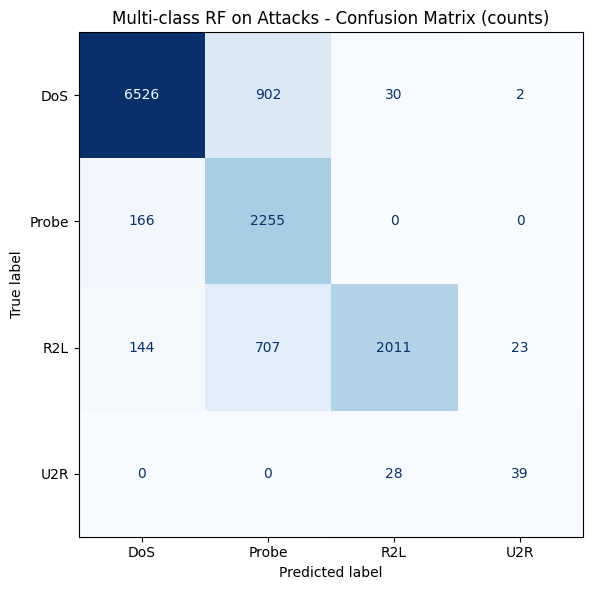

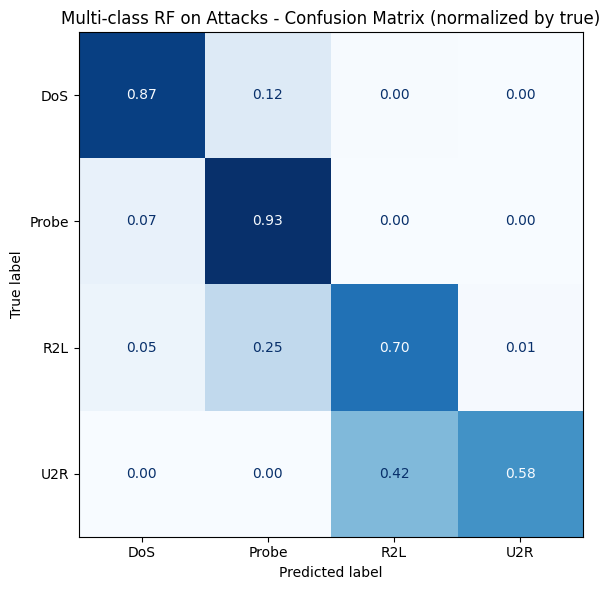

{'precision': 0.7798965273923565,
 'recall': 0.7713438745126697,
 'f1-score': 0.759463309946113,
 'support': 12833.0}

In [59]:
# Cell 10 — Evaluate multi-class (attack-only) with decoded labels for readability
y_pred_attack = multi_model.predict(X_test_attack)

y_test_attack_str = le.inverse_transform(y_test_attack.astype(int))
y_pred_attack_str = le.inverse_transform(y_pred_attack.astype(int))

print("=== Multi-class report (Attack-only RF) ===")
print(classification_report(y_test_attack_str, y_pred_attack_str, digits=4, zero_division=0))

labels_attack_str = sorted(list(set(y_test_attack_str) | set(y_pred_attack_str)))

# Save confusion matrices (string labels)
plot_and_save_confusion_matrix(
    y_test_attack_str, y_pred_attack_str,
    labels=labels_attack_str,
    title="Multi-class RF on Attacks - Confusion Matrix (counts)",
    out_path=FIGURES_DIR / "multi_attack_rf_cm_counts.png",
    normalize=None
)

plot_and_save_confusion_matrix(
    y_test_attack_str, y_pred_attack_str,
    labels=labels_attack_str,
    title="Multi-class RF on Attacks - Confusion Matrix (normalized by true)",
    out_path=FIGURES_DIR / "multi_attack_rf_cm_norm_true.png",
    normalize="true"
)

# Persist report dict
report_dict = classification_report(
    y_test_attack_str,
    y_pred_attack_str,
    output_dict=True,
    zero_division=0
)
save_json(
    {
        "class_weight_numeric": class_weight_numeric,
        "manual_weights_by_label": manual_weights_by_label,
        "labels_attack_str": labels_attack_str,
        "report": report_dict,
    },
    METRICS_DIR / "multi_attack_rf_metrics.json"
)

report_dict.get("macro avg", {})


=== E2E Hierarchical IDS report (decoded labels) ===
              precision    recall  f1-score   support

         DoS     0.8830    0.8724    0.8777      7460
      Normal     0.9290    0.8640    0.8953      9711
       Probe     0.5208    0.9314    0.6680      2421
         R2L     0.9374    0.5653    0.7053      2885
         U2R     0.5205    0.5672    0.5429        67

    accuracy                         0.8349     22544
   macro avg     0.7582    0.7601    0.7378     22544
weighted avg     0.8698    0.8349    0.8397     22544



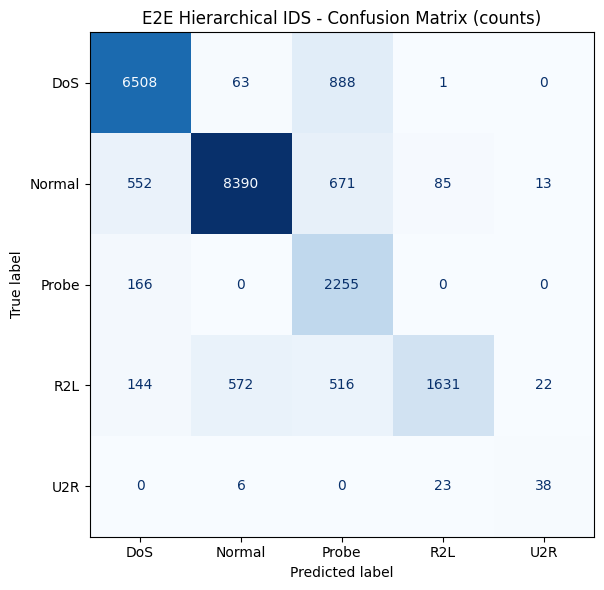

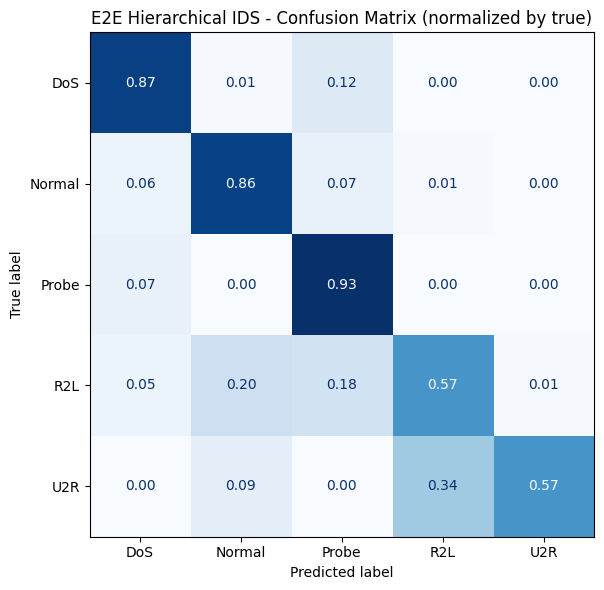

In [60]:

# Cell 11 — End-to-End hierarchical prediction (decoded output)
def hierarchical_predict(X, threshold_for_attack: float):
    """
    Returns:
      - final_pred_codes: numeric codes for final prediction (Normal or attack type code)
      - attack_scores: probability score for Attack from binary model
    """
    proba = binary_model.predict_proba(X)
    if 1 in binary_model.classes_:
        attack_col = int(np.where(binary_model.classes_ == 1)[0][0])
        attack_scores = proba[:, attack_col]
    else:
        attack_scores = np.zeros(X.shape[0], dtype=float)

    is_attack = (attack_scores >= threshold_for_attack)

    final_pred_codes = np.empty(shape=(X.shape[0],), dtype=int)
    final_pred_codes[~is_attack] = NORMAL_CODE

    if np.any(is_attack):
        final_pred_codes[is_attack] = multi_model.predict(X[is_attack]).astype(int)

    return final_pred_codes, attack_scores

# Run E2E
y_pred_e2e_codes, attack_scores_test = hierarchical_predict(X_test, threshold)

# Decode for reports
y_test_str = le.inverse_transform(y_test_multi.astype(int))
y_pred_e2e_str = le.inverse_transform(y_pred_e2e_codes.astype(int))

print("=== E2E Hierarchical IDS report (decoded labels) ===")
print(classification_report(y_test_str, y_pred_e2e_str, digits=4, zero_division=0))

labels_e2e_str = sorted(list(set(y_test_str) | set(y_pred_e2e_str)))

plot_and_save_confusion_matrix(
    y_test_str, y_pred_e2e_str,
    labels=labels_e2e_str,
    title="E2E Hierarchical IDS - Confusion Matrix (counts)",
    out_path=FIGURES_DIR / "e2e_hierarchical_cm_counts.png",
    normalize=None
)

plot_and_save_confusion_matrix(
    y_test_str, y_pred_e2e_str,
    labels=labels_e2e_str,
    title="E2E Hierarchical IDS - Confusion Matrix (normalized by true)",
    out_path=FIGURES_DIR / "e2e_hierarchical_cm_norm_true.png",
    normalize="true"
)


In [61]:
# Cell 12 — Save models & inference artifacts for production/dashboard
artifact = {
    "binary_model": binary_model,
    "multi_model": multi_model,
    "binary_threshold": float(threshold),
    "normal_code": int(NORMAL_CODE),
    "normal_label_str": NORMAL_LABEL_STR,
    "label_encoder_classes": [str(c) for c in le.classes_],
    "feature_names": feature_names,
}

joblib.dump(binary_model, MODELS_DIR / "binary_model.pkl")
joblib.dump(multi_model, MODELS_DIR / "multi_model.pkl")
joblib.dump(le, MODELS_DIR / "label_encoder.pkl")  # handy copy for dashboard
joblib.dump(artifact, MODELS_DIR / "ids_artifact.pkl")

print("Saved:")
print("-", MODELS_DIR / "binary_model.pkl")
print("-", MODELS_DIR / "multi_model.pkl")
print("-", MODELS_DIR / "label_encoder.pkl")
print("-", MODELS_DIR / "ids_artifact.pkl")


Saved:
- C:\Users\elair\Desktop\CS\cyber_bootcamp\Network-Traffic-Anomaly-Detection\results\models\binary_model.pkl
- C:\Users\elair\Desktop\CS\cyber_bootcamp\Network-Traffic-Anomaly-Detection\results\models\multi_model.pkl
- C:\Users\elair\Desktop\CS\cyber_bootcamp\Network-Traffic-Anomaly-Detection\results\models\label_encoder.pkl
- C:\Users\elair\Desktop\CS\cyber_bootcamp\Network-Traffic-Anomaly-Detection\results\models\ids_artifact.pkl


In [62]:
# Cell 13 — Quick preview of predictions
sample_idx = np.random.choice(len(X_test), size=12, replace=False)
pred_codes, scores = hierarchical_predict(X_test[sample_idx], threshold)

df_preview = pd.DataFrame({
    "true": le.inverse_transform(y_test_multi[sample_idx].astype(int)),
    "pred": le.inverse_transform(pred_codes.astype(int)),
    "attack_score": np.round(scores, 4),
})
df_preview


,true,pred,attack_score
0,Normal,Normal,0.0031
1,DoS,DoS,0.5750
2,Normal,Normal,0.0009
3,Normal,Normal,0.0001
4,Normal,Normal,0.0001
5,Probe,Probe,0.4432
6,DoS,DoS,0.1659
7,Normal,Normal,0.0001
8,Normal,Normal,0.0001
9,Normal,Normal,0.0001


In [63]:
# Cell 14 — Notes / tuning checklist (markdown-style comment)
"""
Tuning tips (if R2L/U2R still low):
1) Increase weights for rare classes in manual_weights_by_label:
   e.g., R2L: 10, U2R: 25
2) Lower binary threshold (increase attack recall, may increase false positives).
3) Increase n_estimators, reduce min_samples_leaf for multi_model to fit rare patterns.
4) Consider alternative model for multi stage: GradientBoosting / XGBoost (if allowed).
5) Report macro-F1 and per-class recall; avoid focusing on accuracy.

Engineering note:
- This notebook is robust to numeric labels in y_train_multi/y_test_multi and uses label_encoder.pkl
  to decode/encode Normal & attack types consistently.
"""


'\nTuning tips (if R2L/U2R still low):\n1) Increase weights for rare classes in manual_weights_by_label:\n   e.g., R2L: 10, U2R: 25\n2) Lower binary threshold (increase attack recall, may increase false positives).\n3) Increase n_estimators, reduce min_samples_leaf for multi_model to fit rare patterns.\n4) Consider alternative model for multi stage: GradientBoosting / XGBoost (if allowed).\n5) Report macro-F1 and per-class recall; avoid focusing on accuracy.\n\nEngineering note:\n- This notebook is robust to numeric labels in y_train_multi/y_test_multi and uses label_encoder.pkl\n  to decode/encode Normal & attack types consistently.\n'